# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Monday, July 11 at 5:00 PM

**Late Penalty**:  Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Justin Beland <justin.beland@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:

In [1]:
import csv
import os
import torch
import random
import numpy as np
import torch.utils.data
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# importing the modules
from IPython.display import display

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 


In [5]:
tar_col = ["age", "yredu", "capgain", "caploss", "workhr"]
min_col = df[tar_col].min()
max_col = df[tar_col].max()
print("Original Dataframe")
display(df)

print("Normalized Dataframe")
for col in tar_col:
    diff = max_col[col]-min_col[col]
    if diff != 0:
        df[col] = (df[col]-min_col[col])/diff
    else:
        df[col] = 1
display(df)

Original Dataframe


,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


Normalized Dataframe


,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.021740,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,234721,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,338409,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,Private,257302,Assoc-acdm,0.733333,Married-civ-spouse,Tech-support,Wife,White,Female,0.000000,0.0,0.377551,United-States
32557,0.315068,Private,154374,HS-grad,0.533333,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.000000,0.0,0.397959,United-States
32558,0.561644,Private,151910,HS-grad,0.533333,Widowed,Adm-clerical,Unmarried,White,Female,0.000000,0.0,0.397959,United-States
32559,0.068493,Private,201490,HS-grad,0.533333,Never-married,Adm-clerical,Own-child,White,Male,0.000000,0.0,0.193878,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [6]:
female_per = sum(df["sex"] == " Female")/len(df["sex"])
print("{} % of population in our data set are female".format(female_per*100))

33.07945087681583 % of population in our data set are female


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [7]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [8]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [9]:
miss_record = len(df_with_missing)
unmiss_record = len(df_not_missing)
print("{} records contained missing features".format(miss_record))
print("{} % of records were removed".format(miss_record/(miss_record + unmiss_record)))

1843 records contained missing features
0.056601455729246644 % of records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [10]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [11]:
data = pd.get_dummies(df_not_missing)

In [12]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [13]:
print(len(data.columns))
display(data)

57


,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.021740,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.733333,0.000000,0.0,0.377551,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
32557,0.315068,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
32558,0.561644,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
32559,0.068493,0.533333,0.000000,0.0,0.193878,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


---
There are 57 columns in the dataframe `data`, generated from the `data = pd.get_dummies(df_not_missing)` line. Essentially, all categorical (not number type) value are converted into One-Hot encoding, which means all possible unique categorical value in a single column is turned into multiple columns that has the title encoding as `{original_col}_{unique value}`. Noted that due to One-Hot conversion, the values for these new columns are either **1** or **0**.

This number can also be calculated as follows:

In [14]:
num_col = len(contcols)
for col in catcols:
    num_col += len(set(df_not_missing[col]))
print("num of columns: ", num_col)

num of columns:  57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [15]:
datanp = data.values.astype(np.float32)

In [16]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.

    return cat_values[feature][np.argmax(onehot)]

In [17]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [18]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
# np.random.seed(50)

rng = np.random.default_rng(50)
num_row, num_col = datanp.shape
train_num, val_num = int(num_row*0.7), int(num_row*0.15)
test_num = num_row - train_num - val_num

train_set = rng.choice(datanp, size= train_num)
val_set = rng.choice(datanp, size= val_num)
test_set = rng.choice(datanp, size= test_num)
print("training #： {}\nvalidation #: {}\ntest #: {}".format(train_num, val_num, test_num))

training #： 21502
validation #: 4607
test #: 4609


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [19]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "autoencoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 11), # TODO -- FILL OUT THE CODE HERE!
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

---

Sigmoid function takes any real value input and bounded the input with the range 0-1. This function is necessary for the AutoEncoder as the network is designed to reconstruct the output in the same format as the given input. From the data processing stage, it is established that all input is either normalized to be in the range of 0-1 or constructed from One-Hot encoding which is either 0/1. In brief, all inputs are bounded in the range of 0,1. by having the sigmoid function, the output will be in the same format as the input.

---

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [20]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "./saved_model/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                                 batch_size,
                                                                 learning_rate,
                                                                 epoch)
    return path

def train(model, train_loader, valid_loader, batch_size=64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    #################################################################
    # check if there exists a separate model folder exist for saving pretrained weight
    if not os.path.exists('./saved_model'):
        os.mkdir('./saved_model')

    #################################################################
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, loss_record= [], []
    val_iter, val_loss, val_acc = [], [], []
    n = 0

    progress_total = num_epochs * (len(valid_loader)+ len(train_loader) )
    pbar = tqdm(desc = 'while loop', total = progress_total)

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # print("loss is", loss)
            iters.append(n)
            loss_record.append(float(loss)/batch_size)
            n += 1
            pbar.update(1)

        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    ##################################################################
        val_l = 0
        for val_data in valid_loader:
            datam = zero_out_random_feature(val_data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, val_data)
            optimizer.zero_grad()
            val_l += float(loss)/batch_size
            pbar.update(1)


        val_iter.append(n)
        val_loss.append(val_l/len(valid_loader))

    # plotting
    plt.title("Loss Training Curve")
    plt.plot(iters, loss_record, label="Train")
    plt.plot(val_iter, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

In [21]:
def train_fcn(net, train_set, val_set, batch_size = 64, num_epoch = 30, learning_rate = 1e-3):
    train_l = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
    val_l = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=True)
    train(net, train_l, val_l,batch_size=batch_size, num_epochs=num_epoch,learning_rate=learning_rate)

while loop:   0%|          | 0/12240 [00:00<?, ?it/s]

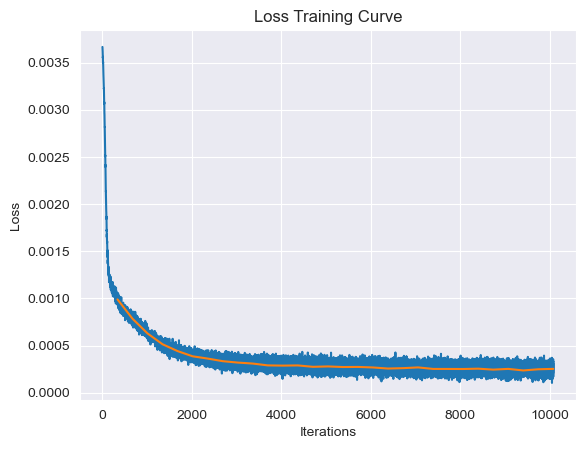

In [22]:
#########################################################
b_s = 64
num_e = 30
lr = 1e-3
#########################################################

autoencoder = AutoEncoder()
train_fcn(autoencoder, train_set, val_set)

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [23]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

In [24]:
def train_acc(model, train_loader, valid_loader, batch_size=64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    #################################################################
    # check if there exists a separate model folder exist for saving pretrained weight
    if not os.path.exists('./saved_model'):
        os.mkdir('./saved_model')

    #################################################################
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, loss_record, epoch_num, acc_record = [], [], [], []
    val_iter, val_loss, val_acc = [], [], []
    n = 0

    progress_total = num_epochs * (len(valid_loader)+ len(train_loader) )
    pbar = tqdm(desc = 'while loop', total = progress_total)

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # print("loss is", loss)
            iters.append(n)
            loss_record.append(float(loss)/batch_size)
            n += 1
            pbar.update(1)

        epoch_num.append(epoch)
        acc_record.append(get_accuracy(model, train_loader))

        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    ##################################################################
        val_l = 0
        for val_data in valid_loader:
            datam = zero_out_random_feature(val_data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, val_data)
            optimizer.zero_grad()
            val_l += float(loss)/batch_size
            pbar.update(1)


        val_iter.append(n)
        val_loss.append(val_l/len(valid_loader))
        val_acc.append(get_accuracy(model, valid_loader))

    # plotting
    plt.title("Loss Training Curve")
    plt.plot(iters, loss_record, label="Train")
    plt.plot(val_iter, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Training Curve")
    plt.plot(epoch_num, acc_record, label="Train")
    plt.plot(epoch_num, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(acc_record[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [25]:
def train_acc_fcn(net, train_set, val_set, batch_size = 64, num_epoch = 30, learning_rate = 1e-3):
    train_l = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
    val_l = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=True)
    train_acc(net, train_l, val_l,batch_size=batch_size, num_epochs=num_epoch,learning_rate=learning_rate)

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

while loop:   0%|          | 0/12240 [00:00<?, ?it/s]

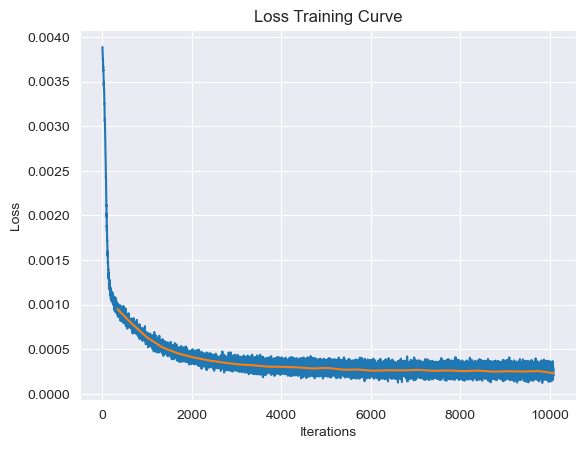

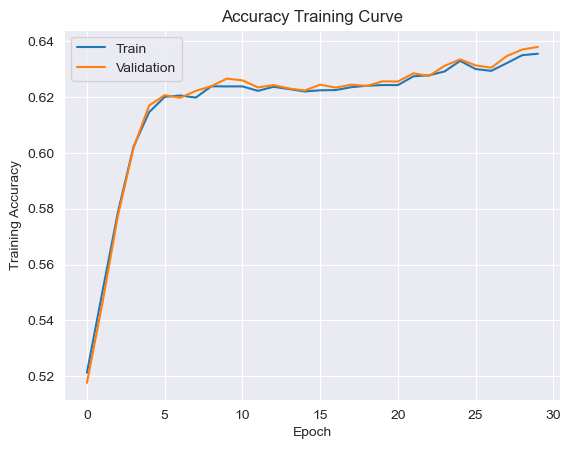

Final Training Accuracy: 0.6355610330821939
Final Validation Accuracy: 0.638014615440272


In [26]:
#########################################################
# this is the default parameters
# b_s = 64
# num_e = 30
# lr = 1e-3
#########################################################

autoencoder = AutoEncoder()
train_acc_fcn(autoencoder, train_set, val_set)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

`Default Parameters`


*   Batch Size = 64
*   number of Epoches = 30
*   learning rate = 0.001

*training accuracy: 63.5%*
*validation accuracy: 63.3%*


---


After trying the default parameter, the curve graph shows that the validation accuracy is slightly above the training accuracy, which is a signal of overfitting training, as a result, I decided to decrease the batch size from 64 to 32 to create smaller batches (smaller batches might have more noises) to produce lower generalization error.

*   Batch Size = 32
*   number of Epoches = 30
*   learning rate = 0.001

*training accuracy: 64.0%*
*validation accuracy: 63.8%*


---
At the end of the accuracy learning curve, a slight fluctuating trend can still be observed on the graph, so I decided to reduce the learning rate to see if it can smoothen the curve and increase the accuracy.

*   Batch Size = 32
*   number of Epoches = 30
*   learning rate = 0.0001

*training accuracy: 61.8%*
*validation accuracy: 62.2%*


---
At the end of the accuracy learning curve, an increasing trend can still be observed on the graph, so I decided to increase the learning rate again to see if the curve can reach a plateau at the 30th epoch.

*   Batch Size = 32
*   number of Epoches = 30
*   learning rate = 0.0005

*training accuracy: 63.0%*
*validation accuracy: 62.7%*


---
Although the graph is slightly overfitting, at the end of the accuracy learning curve, an sudden increasing trend for both training and validation curve can be observed at the 29th epoch, so I decided to double the epoch number to see if the increasing trend will continue.

*   Batch Size = 32
*   number of Epoches = 60
*   learning rate = 0.0005

*training accuracy: 62.5%*
*validation accuracy: 62.6%*


---
The following parameter acchives the highest accuracy in both training and validation dataset:
*   Batch Size = 32
*   number of Epoches = 30
*   learning rate = 0.001


while loop:   0%|          | 0/24480 [00:00<?, ?it/s]

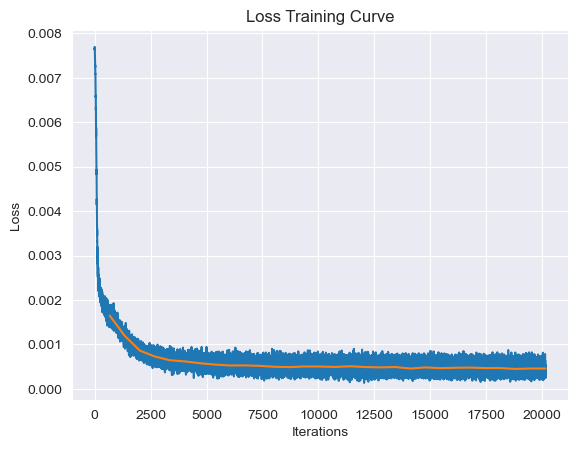

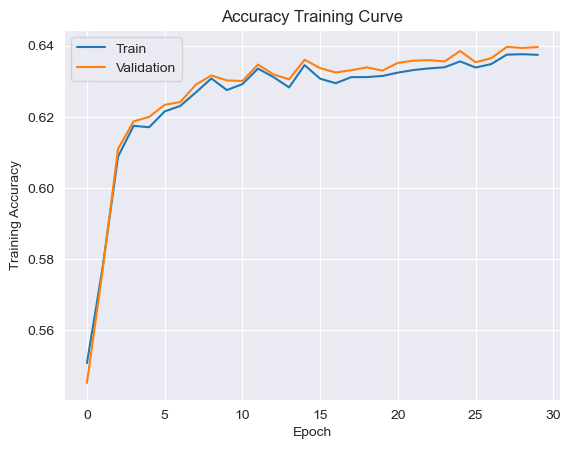

Final Training Accuracy: 0.6374523300158125
Final Validation Accuracy: 0.6396425728963172


In [27]:
#########################################################
b_s = 32
num_e = 30
lr = 1e-3
#########################################################

autoencoder = AutoEncoder()
train_acc_fcn(autoencoder, train_set, val_set,batch_size=b_s, num_epoch=num_e, learning_rate=lr)

while loop:   0%|          | 0/24480 [00:00<?, ?it/s]

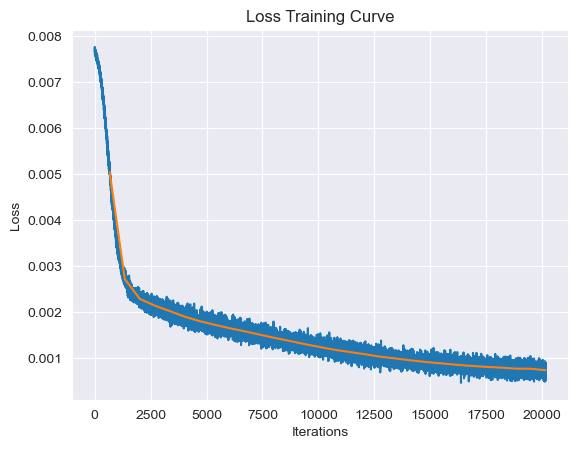

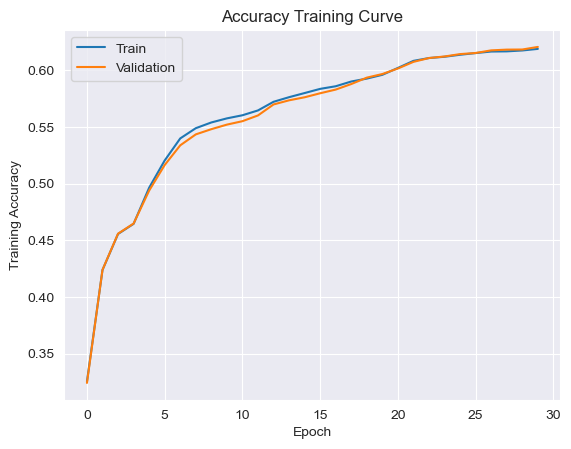

Final Training Accuracy: 0.6188106532725638
Final Validation Accuracy: 0.6205412054120542


In [28]:
#########################################################
b_s = 32
num_e = 30
lr = 1e-4
#########################################################

autoencoder = AutoEncoder()
train_acc_fcn(autoencoder, train_set, val_set,batch_size=b_s, num_epoch=num_e, learning_rate=lr)

while loop:   0%|          | 0/24480 [00:00<?, ?it/s]

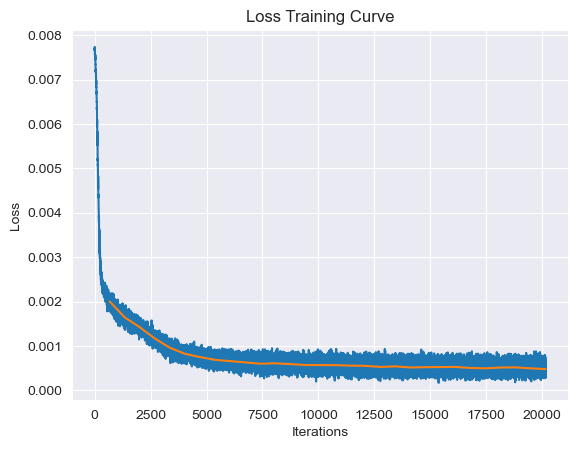

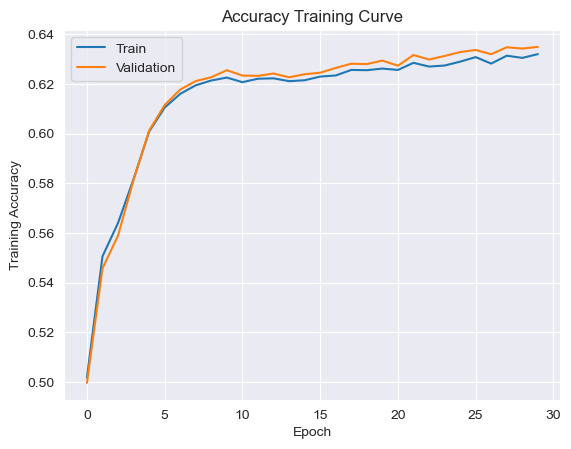

Final Training Accuracy: 0.6319644684215422
Final Validation Accuracy: 0.6348672310252514


In [29]:
#########################################################
b_s = 32
num_e = 30
lr = 5e-4
#########################################################

autoencoder = AutoEncoder()
train_acc_fcn(autoencoder, train_set, val_set,batch_size=b_s, num_epoch=num_e, learning_rate=lr)

while loop:   0%|          | 0/48960 [00:00<?, ?it/s]

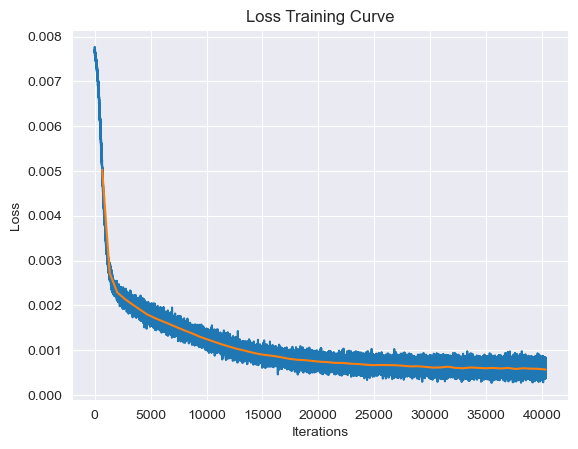

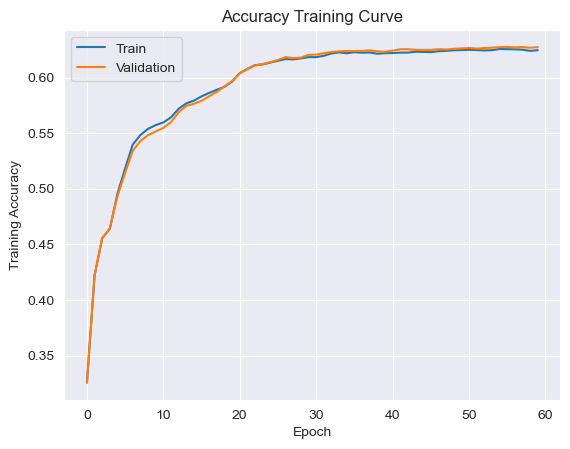

Final Training Accuracy: 0.6245620562428301
Final Validation Accuracy: 0.6273062730627307


In [30]:
#########################################################
b_s = 32
num_e = 60
lr = 1e-4
#########################################################

autoencoder = AutoEncoder()
train_acc_fcn(autoencoder, train_set, val_set,batch_size=b_s, num_epoch=num_e, learning_rate=lr)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [31]:
test_loader = torch.utils.data.DataLoader(test_set,batch_size=32, shuffle=True)

net = AutoEncoder()
net.load_state_dict(torch.load('./saved_model/model_autoencoder_bs32_lr0.001_epoch29'))
print(get_accuracy(net, test_loader))

0.6410645837853475


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [32]:
# this is copied from part b
def get_baseline_accuracy(data_loader):
    """Return the "accuracy" of the baseline prediction model across a data set.
    The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - data_loader: an instance of torch.utils.data.DataLoader
    """
    cat_dict = {}
    for col in catcols:
        col_dict = {}
        for item in data_loader: # minibatches
            for ele in range(item.shape[0]):
                feat = get_feature(item[ele], col)
                if feat in col_dict:
                    col_dict[feat] += 1
                else:
                    col_dict[feat] = 1
        cat_dict[col] = col_dict
        max_k = max(col_dict, key = col_dict.get)
        cat_dict[col] = max_k


    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            zero_out_feature(item.clone(), col)
            # out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(item.shape[0]): # record in minibatch
                acc += int(cat_dict[col] == get_feature(inp[i], col))
                total += 1
    return acc / total

In [33]:
get_baseline_accuracy(test_loader)

0.467093368048022

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

---

The Autoencoder accuracy from part(a), 64.247%, is higher than the baseline test accuracy in part(b), 46.709%, by **37.5%**. This result shows that our autoencoder model is actually performing well.


---

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

---
The other given parameters include age, workclass, hours-per-week, education-num, capital gain, capital loss, work, marriage, occupation, relationship, sex, etc. I think there is a certain level of correlation between `education` and some of the other parameters such as `workclass` `occupation` `education-num` (ex. number of years of education is directly related to the education, and some occupation also requires certain level of education). However, there are also a lot of other irrelevant features such as `relationship` `sex` `age`. These factors might act as distractors in the autoencoder as they may impact the loss value.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [34]:
#####################################################
# preparing the person's blank data
test_loader = torch.utils.data.DataLoader(test_set,batch_size=32, shuffle=False)

col = 'edu'
person = next(iter(test_loader))
inp = person.detach().numpy()
data = zero_out_feature(person.clone(), col)
####################################################
# loading net
net = AutoEncoder()
net.load_state_dict(torch.load('./saved_model/model_autoencoder_bs32_lr0.001_epoch29'))
out = net(data).detach().numpy()
print("the model's prediction for education level: ", get_feature(out[0], col))

the model's prediction for education level:  HS-grad


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [35]:
col = 'edu'
col_dict = {}
for item in test_loader: # minibatches
    for ele in range(item.shape[0]):
        feat = get_feature(item[ele], col)
        if feat in col_dict:
            col_dict[feat] += 1
        else:
            col_dict[feat] = 1
max_k = max(col_dict, key = col_dict.get)

print("baseline's prediction for education level: ", max_k)

baseline's prediction for education level:  HS-grad
